##  Sparse Model Verification

This script verifies output from a ML-based foundation model versus a
traditional NWP system for the atmospheric system. The defaults set at the top of
this script are tailored to the Alps-Clariden HPC system at CSCS.
- The NWP-model is called COSMO-E and is initialised with the ensemble mean of the analysis. Only surface level data is available in the archive at MeteoSwiss.
- The ML-model is called Neural-LAM and is initialised with the deterministic analysis.
- The Ground Truth are surface level observations from MeteoSwiss.

For more info about the COSMO model see:
- https://www.cosmo-model.org/content/model/cosmo/coreDocumentation/cosmo_io_guide_6.00.pdf
- https://www.research-collection.ethz.ch/handle/20.500.11850/720460

In [2]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.diagnostics import ProgressBar
from scipy.spatial import cKDTree
from scipy.stats import kurtosis, skew, wasserstein_distance
from scores.categorical import ThresholdEventOperator as TEO
from scores.continuous import (
    mae,
    mean_error,
    mse,
    rmse,
)
from scores.continuous.correlation import pearsonr

In [3]:
### DEFAULTS ###
# This config will be applied to the data before any plotting. The data will be
# sliced and indexed according to the values in this config.The whole analysis and
# plotting will be done on the reduced data.

# IF YOUR DATA HAS DIFFERENT DIMENSIONS OR NAMES, PLEASE ADJUST THE CELLS BELOW
# MAKE SURE THE XARRAY DATASETS LOOK OKAY BEFORE RUNNING CHAPTER 1-4

# This path should point to the NWP forecast data in zarr format
PATH_NWP = "/capstor/store/cscs/swissai/a01/sadamov/cosmo_e_forecast.zarr"
# This path should point to the ML forecast data in zarr format (e.g. produced by neural-lam in `eval` mode)
#PATH_ML = "/iopsstor/scratch/cscs/sadamov/pyprojects_data/neural-lam/eval_results/preds_7_19_margin_interior_lr_0001_ar_12.zarr"
PATH_ML = "/iopsstor/scratch/cscs/joeos/neural_lam_data/preds_7_19_margin_interior_lr_0001_ar_12.zarr"
# This path should point to the observations data in zarr format
PATH_OBS = "/capstor/store/cscs/swissai/a01/sadamov/cosmo_observations.zarr"

# All variables should map to the same values.
# For obs please also theck the pre-processing in the cell below
# Often some data wrangling is required to match the variables
# OBS and ML variables should match and always be present
VARIABLES_ML = {
    "T_2M": "temperature_2m",
    "U_10M": "wind_u_10m",
    "V_10M": "wind_v_10m",
    "PS": "surface_pressure",
    "TOT_PREC": "precipitation",
}
# The function calls are flexible to allow for missing nwp data
VARIABLES_NWP = {
    "temperature_2m": "temperature_2m",
    "wind_u_10m": "wind_u_10m",
    "wind_v_10m": "wind_v_10m",
    "surface_pressure": "surface_pressure",
    "precipitation_1hr": "precipitation",
}
VARIABLES_OBS = [
    "air_temperature",
    "wind_speed",
    "wind_direction",
    "air_pressure",
    "precipitation",
]

# Add units dictionary after the imports
# units from zarr archives are not reliable and should rather be defined here
VARIABLE_UNITS = {
    # Surface and near-surface variables
    "temperature_2m": "K",
    "wind_u_10m": "m/s",
    "wind_v_10m": "m/s",
    "surface_pressure": "Pa",
    "precipitation": "mm/h",
}

# elapsed forecast duration in steps for the forecast - [0] refers to the first forecast step at t+1
# this should be a list of integers
ELAPSED_FORECAST_DURATION = list(range(0, 120, 1))  # used for time series
#ELAPSED_FORECAST_DURATION = [0, 23, 47, 71, 95, 119] # used for maps

# Select specific start_times for the forecast. This is the start and end of
# a slice in xarray. The start_time is included, the end_time is excluded.
# This should be a list of two strings in the format "YYYY-MM-DDTHH:MM:SS"
# Should be handy to evaluate certain dates, e.g. for a case study of a storm
START_TIMES = ["2019-10-31T00:00:00", "2020-10-23T13:00:00"]  # Full year
# START_TIMES = ["2020-02-08T00:00:00", "2020-02-15T00:00:00"]  # Ciara/Sabine

# Select specific plot times for the forecast (will be used to create maps for all variables)
# This only affect chapter one with the plotting of the maps
# Map creation takes a lot of time so this is limited to a single time step
# Simply rerun these cells and chapter one for more time steps
PLOT_TIME = "2020-02-07T00:00:00"

# Define Thresholds for the ETS metric (Equitable Threat Score)
# These are calculated for wind and precipitation if available
# The score creates contingency tables for different thresholds
# The ETS is calculated for each threshold and the results are plotted
# The default thresholds are [0.1, 1, 5] for precipitation and [2.5, 5, 10] for wind
THRESHOLDS_PRECIPITATION = [0.1, 1, 5]  # mm/h
THRESHOLDS_WIND = [2.5, 5, 10]  # m/s

# Define the metrics to compute for the verification
# Some additional verifications will always be computed if the repsective vars
# are available in the data
METRICS = [
    # "MAE",
    "RMSE",
    # "MSE",
    "ME",
    "STDEV_ERR",
    # "RelativeMAE",
    # "RelativeRMSE",
    # "PearsonR",
    "Wasserstein",
]

# Map projection settings for plotting of the ml data
PROJECTION = ccrs.RotatedPole(
    pole_longitude=190,
    pole_latitude=43,
    central_rotated_longitude=10,
)

# For some chapters a random seed is required to reproduce the results
RANDOM_SEED = 42

# The DPI used in all plots in the notebook, export to pdf will always be 300 DPI
DPI = 100

# Takes a long time, but if you see NaN in your output, you can set this to True
# This will check if there are any missing values in the data further below
CHECK_MISSING = True
# In this script missing data is allowed as observations often have missing values
# All time steps with missing values will be omitted from the verification
# - Scores/Xarray masked arrays are created and false values are omitted by default
# - For Scipy metrics, we need to convert to numpy arrays and change nan-policy to 'omit'.
# - Fore the wasserstein metric and the wind vector without internal nan-handling policy,
#  we need to remove the missing values for obs, ml, nwp before calculating the metric

# Font sizes for consistent plotting (different fig-sizes wil require different font sizes)
FONT_SIZES = {
    "axes": 24,  # Axis labels and titles
    "ticks": 24,  # Tick labels
    "legend": 22,  # Legend text
    "cbar": 24,  # Colorbar labels
    "suptitle": 24,  # Figure suptitle
    "title": 24,  # Axes titles
    "stats": 22,  # Statistics text in plots
}

In [4]:
# Create directories for plots and tables
Path("plots").mkdir(exist_ok=True)
Path("tables").mkdir(exist_ok=True)

# Accessible color palette
COLORS = {
    "gt": "#000000",  # Black
    "ml": "#E69F00",  # Orange
    "nwp": "#56B4E9",  # Light blue
    "error": "#CC79A7",  # Pink
}

# Line styles and markers for accessibility
LINE_STYLES = {
    "gt": ("solid", "o"),
    "ml": ("dashed", "s"),
    "nwp": ("dotted", "^"),
}

# Set global font sizes
plt.rcParams.update({
    "font.size": FONT_SIZES["axes"],
    "axes.titlesize": FONT_SIZES["axes"],
    "axes.labelsize": FONT_SIZES["axes"],
    "xtick.labelsize": FONT_SIZES["ticks"],
    "ytick.labelsize": FONT_SIZES["ticks"],
    "legend.fontsize": FONT_SIZES["legend"],
    "figure.titlesize": FONT_SIZES["suptitle"],
})

# Colorblind-friendly colormap for 2D plots
COLORMAP = "viridis"


def save_plot(fig, name, time=None, remove_title=True, dpi=300):
    """Helper function to save plots consistently

    Args:
        fig: matplotlib figure object
        name (str): base name for the plot file
        time (datetime, optional): timestamp to append to filename
        remove_title (bool): remove suptitle/title hierarchically if True
        dpi (int): resolution for the saved figure, defaults to 300
    """
    if time is not None:
        name = f"{name}_{time.dt.strftime('%Y%m%d_%H').values}"

    # Sanitize filename by replacing problematic characters
    safe_name = name.replace("/", "_per_")

    # Normalize the path and ensure plots directory exists
    plot_dir = Path("plots")
    plot_dir.mkdir(exist_ok=True)

    # Remove titles if requested
    if remove_title:
        if hasattr(fig, "texts") and fig.texts:  # Check for suptitle
            fig.suptitle("")
        ax = fig.gca()
        if ax.get_title():
            ax.set_title("")

    pdf_path = plot_dir / f"observations_{safe_name}.pdf"
    fig.savefig(pdf_path, bbox_inches="tight", dpi=dpi)


def export_table(df, name, caption=""):
    """Helper function to export tables consistently"""
    # Export to LaTeX with caption
    latex_str = df.to_latex(
        float_format="%.4f", caption=caption, label=f"tab:{name}"
    )
    with open(f"tables/observations_{name}.tex", "w") as f:
        f.write(latex_str)

    # Export to CSV
    df.to_csv(f"tables/observations_{name}.csv")

In [5]:
ds_nwp = xr.open_zarr(PATH_NWP)
ds_nwp = ds_nwp.sel(time=slice(*START_TIMES))
ds_nwp = ds_nwp[VARIABLES_NWP.keys()].rename(VARIABLES_NWP)
ds_nwp = ds_nwp.rename_dims({
    "lead_time": "elapsed_forecast_duration",
    "time": "start_time",
})
ds_nwp = ds_nwp.rename_vars({
    "lead_time": "elapsed_forecast_duration",
    "time": "start_time",
    "lon": "longitude",
    "lat": "latitude",
})
forecast_times = (
    ds_nwp.start_time.values[:, None] + ds_nwp.elapsed_forecast_duration.values
)
ds_nwp = ds_nwp.assign_coords(
    forecast_time=(
        ("start_time", "elapsed_forecast_duration"),
        forecast_times,
    )
)

# # Calculate hourly values by taking differences along elapsed_forecast_duration
ds_nwp["precipitation"] = ds_nwp.precipitation.diff(
    dim="elapsed_forecast_duration"
)
# The NWP data starts at elapsed forecast duration 0 = start_time
ds_nwp = ds_nwp.drop_isel(elapsed_forecast_duration=0).isel(
    elapsed_forecast_duration=ELAPSED_FORECAST_DURATION
)

ds_nwp = ds_nwp.transpose("start_time", "elapsed_forecast_duration", "x", "y")
ds_nwp = ds_nwp[
    [
        "start_time",
        "elapsed_forecast_duration",
        "x",
        "y",
        *VARIABLES_NWP.values(),
    ]
]

ds_nwp

/users/sadamov/miniforge3/envs/neural-lam/lib/python3.12/site-packages/dask/array/core.py:5092: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(


<xarray.Dataset> Size: 39GB
Dimensions:                    (start_time: 718, elapsed_forecast_duration: 6,
                                x: 582, y: 390)
Coordinates:
  * start_time                 (start_time) datetime64[ns] 6kB 2019-10-31 ......
  * elapsed_forecast_duration  (elapsed_forecast_duration) timedelta64[ns] 48B ...
  * x                          (x) int64 5kB 0 1 2 3 4 5 ... 577 578 579 580 581
  * y                          (y) int64 3kB 0 1 2 3 4 5 ... 385 386 387 388 389
    latitude                   (x, y) float64 2MB dask.array<chunksize=(291, 195), meta=np.ndarray>
    longitude                  (x, y) float64 2MB dask.array<chunksize=(291, 195), meta=np.ndarray>
    forecast_time              (start_time, elapsed_forecast_duration) datetime64[ns] 34kB ...
Data variables:
    temperature_2m             (start_time, elapsed_forecast_duration, x, y) float64 8GB dask.array<chunksize=(2, 6, 146, 98), meta=np.ndarray>
    wind_u_10m                 (start_time, elapsed_forecast_duration, x, y) float64 8GB dask.array<chunksize=(2, 6, 146, 98), meta=np.ndarray>
    wind_v_10m                 (start_time, elapsed_forecast_duration, x, y) float64 8GB dask.array<chunksize=(2, 6, 146, 98), meta=np.ndarray>
    surface_pressure           (start_time, elapsed_forecast_duration, x, y) float64 8GB dask.array<chunksize=(2, 6, 146, 98), meta=np.ndarray>
    precipitation              (start_time, elapsed_forecast_duration, x, y) float64 8GB dask.array<chunksize=(2, 6, 146, 98), meta=np.ndarray>

In [6]:
ds_ml = xr.open_zarr(PATH_ML)
ds_ml = ds_ml.sel(state_feature=list(VARIABLES_ML.keys()))
ds_ml = ds_ml.sel(start_time=slice(*START_TIMES))
for feature in ds_ml.state_feature.values:
    ds_ml[VARIABLES_ML[feature]] = ds_ml["state"].sel(state_feature=feature)
forecast_times = (
    ds_ml.start_time.values[:, None] + ds_ml.elapsed_forecast_duration.values
)
ds_ml = ds_ml.assign_coords(
    forecast_time=(
        ("start_time", "elapsed_forecast_duration"),
        forecast_times,
    )
)
ds_ml = ds_ml.drop_vars(["state", "state_feature", "time"])
ds_ml = ds_ml.transpose("start_time", "elapsed_forecast_duration", "x", "y")
ds_ml = ds_ml[
    [
        "start_time",
        "elapsed_forecast_duration",
        "x",
        "y",
        *VARIABLES_ML.values(),
    ]
]
ds_ml = ds_ml.assign_coords({
    "latitude": ds_nwp.latitude,
    "longitude": ds_nwp.longitude,
})

ds_ml = ds_ml.isel(elapsed_forecast_duration=ELAPSED_FORECAST_DURATION)

ds_ml

<xarray.Dataset> Size: 20GB
Dimensions:                    (start_time: 718, elapsed_forecast_duration: 6,
                                x: 582, y: 390)
Coordinates:
  * start_time                 (start_time) datetime64[ns] 6kB 2019-10-31 ......
  * elapsed_forecast_duration  (elapsed_forecast_duration) timedelta64[ns] 48B ...
  * x                          (x) int64 5kB 0 1 2 3 4 5 ... 577 578 579 580 581
  * y                          (y) int64 3kB 0 1 2 3 4 5 ... 385 386 387 388 389
    forecast_time              (start_time, elapsed_forecast_duration) datetime64[ns] 34kB ...
    latitude                   (x, y) float64 2MB dask.array<chunksize=(291, 195), meta=np.ndarray>
    longitude                  (x, y) float64 2MB dask.array<chunksize=(291, 195), meta=np.ndarray>
Data variables:
    temperature_2m             (start_time, elapsed_forecast_duration, x, y) float32 4GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    wind_u_10m                 (start_time, elapsed_forecast_duration, x, y) float32 4GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    wind_v_10m                 (start_time, elapsed_forecast_duration, x, y) float32 4GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    surface_pressure           (start_time, elapsed_forecast_duration, x, y) float32 4GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>
    precipitation              (start_time, elapsed_forecast_duration, x, y) float32 4GB dask.array<chunksize=(1, 1, 582, 390), meta=np.ndarray>

In [7]:
OBS_VAR_MAPPING = {
    "air_temperature": "temperature_2m",
    "air_pressure": "surface_pressure",
    "precipitation": "precipitation",
}


def calculate_wind_components(
    ds, speed_var="wind_speed", dir_var="wind_direction"
):
    """Calculate u and v wind components from speed and direction.

    Args:
        ds: xarray Dataset containing wind speed and direction
        speed_var: name of wind speed variable
        dir_var: name of wind direction variable (meteorological convention, 0=N, 90=E)

    Returns:
        ds: Dataset with new wind_u_10m (+ = eastward) and wind_v_10m (+ = northward)
    """
    ds = ds.copy()
    ds["wind_u_10m"] = -ds[speed_var] * np.sin(np.radians(ds[dir_var]))
    ds["wind_v_10m"] = -ds[speed_var] * np.cos(np.radians(ds[dir_var]))
    ds = ds.drop_vars([speed_var, dir_var])
    return ds


ds_obs = xr.open_zarr(PATH_OBS)
ds_obs = ds_obs[VARIABLES_OBS].rename_vars(OBS_VAR_MAPPING)
ds_obs = ds_obs.sel(time=np.unique(ds_ml.forecast_time.values.flatten()))
ds_obs = ds_obs.where(ds_obs != 32767, np.nan)
ds_obs = calculate_wind_components(ds_obs)
ds_obs["temperature_2m"] += 273.15  # Convert to Kelvin
ds_obs["surface_pressure"] *= 100  # Convert to Pa
ds_obs

<xarray.Dataset> Size: 9MB
Dimensions:           (time: 1444, station: 158)
Coordinates:
    latitude          (station) float64 1kB dask.array<chunksize=(158,), meta=np.ndarray>
    longitude         (station) float64 1kB dask.array<chunksize=(158,), meta=np.ndarray>
  * station           (station) int64 1kB 1 2 3 4 6 7 ... 915 952 1024 1118 1435
  * time              (time) datetime64[ns] 12kB 2019-10-31T01:00:00 ... 2020...
Data variables:
    temperature_2m    (time, station) float64 2MB dask.array<chunksize=(1444, 40), meta=np.ndarray>
    surface_pressure  (time, station) float64 2MB dask.array<chunksize=(1444, 40), meta=np.ndarray>
    precipitation     (time, station) float64 2MB dask.array<chunksize=(1444, 40), meta=np.ndarray>
    wind_u_10m        (time, station) float64 2MB dask.array<chunksize=(1444, 40), meta=np.ndarray>
    wind_v_10m        (time, station) float64 2MB dask.array<chunksize=(1444, 40), meta=np.ndarray>
Attributes:
    description:  Weather station data
    parameters:   {'1739': {'description': 'Air temperature 2 m above ground;...

Check for missing data in any of the variables. If you have missing data and don't treat it properly, the corresponding time steps will be removed from the evaluation. This can lead to a bias in the evaluation.

In [8]:
def analyze_missing_data(ds_obs):
    """
    Create a 2D table of missing data percentages by variable and month.

    Args:
        ds_obs (xarray.Dataset): Observation dataset
    """
    # Convert time to pandas datetime for month extraction
    times = pd.DatetimeIndex(ds_obs.time.values)

    # Calculate total stations with missing data
    stations_with_missing = len([
        station
        for station in ds_obs.station
        if np.isnan(ds_obs.sel(station=station)).any()
    ])

    # Initialize results dictionary
    missing_by_month = {}

    # Calculate percentages for each variable and month
    for var in ds_obs.data_vars:
        missing_by_month[var] = {}
        for month in range(1, 13):
            month_mask = times.month == month
            if not any(month_mask):
                continue

            total_elements = ds_obs.sizes["station"] * month_mask.sum()
            n_missing = (
                np.isnan(ds_obs[var].sel(time=ds_obs.time[month_mask]))
                .sum()
                .values
            )
            missing_by_month[var][month] = (n_missing / total_elements) * 100

    # Create DataFrame
    df = pd.DataFrame(missing_by_month)

    # Format percentages to 2 decimal places
    df = df.round(2)

    # Print summary and table
    print(
        f"\nMissing Data Analysis: {stations_with_missing} out of {ds_obs.sizes['station']} stations affected"
    )
    print("Percentage of Missing Values by Variable and Month:")
    print("=" * 50)
    print(df)

    return df


# Call the function
if CHECK_MISSING:
    analyze_missing_data(ds_obs)


Missing Data Analysis: 158 out of 158 stations affected
Percentage of Missing Values by Variable and Month:
    temperature_2m  surface_pressure  precipitation  wind_u_10m  wind_v_10m
1             6.43             13.33          12.69        5.11        5.11
2             6.50             13.35          12.73        5.39        5.39
3             6.58             13.29          12.88        5.24        5.24
4             6.53             13.47          12.96        5.06        5.06
5             6.33             13.29          12.66        5.07        5.07
6             6.53             13.29          12.85        5.30        5.30
7             6.50             13.34          12.75        5.31        5.31
8             6.36             13.33          12.72        5.16        5.16
9             6.34             13.30          12.67        5.23        5.23
10            6.49             13.39          12.84        5.42        5.42
11            6.81             13.35          12.84    

In [9]:
assert ds_obs.sizes["time"] == len(
    np.unique(ds_ml.forecast_time.values.flatten())
), (
    f"Number of time steps do not match: {ds_obs.sizes['time']} != {len(np.unique(ds_ml.forecast_time.values.flatten()))}"
)
assert ds_ml.sizes["start_time"] == ds_nwp.sizes["start_time"]

Interpolation from the gridded model data to the station locations is done using the nearest neighbor method. Since we are only looking at surface level data, this is a reasonable approach. However, if you are working with data at different levels, you may want to consider a more sophisticated interpolation method. 

In [10]:
def interpolate_to_obs(
    ds_model_1, ds_model_2, ds_obs, vars_plot, neighbors=None
):
    """Interpolate model datasets to observation points using xarray/dask in rotated pole coordinates."""

    print("Starting optimized interpolation in rotated pole projection...")

    # Project before computing distances and weights
    source_crs = ccrs.PlateCarree()
    # Transform the coordinates

    # Extract observation coordinates

    points_obs = PROJECTION.transform_points(
        source_crs,
        ds_obs.longitude.values,
        ds_obs.latitude.values,
    )[:, :2]

    # Extract model coordinates from 2D lat/lon arrays
    model_lats = ds_model_1.latitude
    model_lons = ds_model_1.longitude

    points_model = PROJECTION.transform_points(
        source_crs,
        model_lons.values.ravel(),
        model_lats.values.ravel(),
    )[:, :2]

    # Build KDTree with rotated coordinates
    print("Building KD-tree and finding neighbors...")
    k = 4 if neighbors is None else neighbors
    kdtree = cKDTree(points_model)
    distances, flat_indices = kdtree.query(points_obs, k=k)

    # Convert flat indices back to 2D indices
    _, ny = ds_model_1.x.size, ds_model_1.y.size
    x_indices = flat_indices // ny
    y_indices = flat_indices % ny

    # Compute weights
    weights = xr.DataArray(
        1.0 / (distances + 1e-10), dims=["station", "neighbor"]
    )
    weights = weights / weights.sum("neighbor")

    def interpolate_variable(var):
        print(f"Processing variable: {var}")
        data_1 = ds_model_1[var].isel(
            x=xr.DataArray(x_indices, dims=["station", "neighbor"]),
            y=xr.DataArray(y_indices, dims=["station", "neighbor"]),
        )
        data_2 = ds_model_2[var].isel(
            x=xr.DataArray(x_indices, dims=["station", "neighbor"]),
            y=xr.DataArray(y_indices, dims=["station", "neighbor"]),
        )
        return (
            var,
            (data_1 * weights).sum(dim="neighbor"),
            (data_2 * weights).sum(dim="neighbor"),
        )

    # Process all variables
    results = {var: interpolate_variable(var)[1:] for var in vars_plot}

    # Create output datasets
    ds_interp_1 = xr.Dataset(
        {var: results[var][0] for var in vars_plot},
        coords={
            "start_time": ds_model_1.start_time,
            "elapsed_forecast_duration": ds_model_1.elapsed_forecast_duration,
            "station": ds_obs.station,
            "forecast_time": ds_model_1.forecast_time,
            "latitude": ds_obs.latitude,
            "longitude": ds_obs.longitude,
        },
    )

    ds_interp_2 = xr.Dataset(
        {var: results[var][1] for var in vars_plot},
        coords={
            "start_time": ds_model_2.start_time,
            "elapsed_forecast_duration": ds_model_2.elapsed_forecast_duration,
            "station": ds_obs.station,
            "forecast_time": ds_model_2.forecast_time,
            "latitude": ds_obs.latitude,
            "longitude": ds_obs.longitude,
        },
    )

    return ds_interp_1, ds_interp_2


# Use the function
ds_ml_interp, ds_nwp_interp = interpolate_to_obs(
    ds_ml, ds_nwp, ds_obs, VARIABLES_ML.values(), neighbors=4
)

# from dask.distributed import Client, LocalCluster
# with (
#     LocalCluster(
#         n_workers=4,
#         threads_per_worker=32,
#         memory_limit="96GB",
#         local_directory="/iopsstor/scratch/cscs/sadamov",  # Use fast local storage for spilling
#         dashboard_address=None,
#     ) as cluster
# ):
#     with Client(cluster) as client:
with ProgressBar():
    print("Computing interpolated datasets...")
    ds_ml_interp = ds_ml_interp.compute()
    print("ML interpolation done.")
    ds_nwp_interp = ds_nwp_interp.compute()
    print("NWP interpolation done.")


Starting optimized interpolation in rotated pole projection...
Building KD-tree and finding neighbors...
Processing variable: temperature_2m
Processing variable: wind_u_10m
Processing variable: wind_v_10m
Processing variable: surface_pressure
Processing variable: precipitation
Computing interpolated datasets...
[########################################] | 100% Completed | 504.26 s
ML interpolation done.
[########################################] | 100% Completed | 54m 34s
NWP interpolation done.


### 3. Various Verification Metrics
The final chapter consolidates various statistical metrics to provide a broad
evaluation of the ML model's performance. By considering multiple metrics, we
gain a nuanced understanding of both the strengths and weaknesses of the model.

**Metric Diversity:** Including ME, STDEV-ERR, MAE, RMSE, MSE, Pearson correlation, covers different aspects of model performance, from average errors to spatial pattern accuracy.

**ME** (Mean Error): Indicates the average discrepancy between the model and ground truth values. A positive value indicates that the model tends to overestimate, while a negative value suggests underestimation. Also called Bias.

**STDEV-ERR** (Standard Deviation of Errors): Shows the variability of errors, highlighting whether the model is consistent in its predictions.

**MAE, MSE and RMSE:** Offer insights into the average magnitude of errors, with
RMSE emphasizing larger discrepancies. The colors indicating high errors are
only implemented for these three metrics with standardization.

**Pearson Correlation:** Assesses the linear relationship, indicating whether
the model captures variability even if biases exist.

**Wasserstein Distance:** Provides a holistic view of distributional similarity
across variables. Same as chapter 3.

**Holistic Assessment:** The combination of metrics provides a comprehensive
performance profile, essential for model validation and comparison. More complex metrics are explained in more detail.

In [13]:
def calculate_metrics_by_efd(
    ds_obs,
    ds_ml,
    ds_nwp=None,
    metrics_to_compute=None,
    prefix="metrics",
):
    """Calculate metrics for each Elapsed Forecast Duration for station data using xarray."""
    if metrics_to_compute is None:
        metrics_to_compute = METRICS

    variables = list(ds_obs.data_vars)
    elapsed_forecast_durations = ds_ml.elapsed_forecast_duration
    elapsed_forecast_durations_hours = elapsed_forecast_durations.values.astype(
        "timedelta64[s]"
    ) / np.timedelta64(1, "h")

    metrics_by_efd = {}
    combined_metrics = {}

    for efd, lt_hours in zip(
        elapsed_forecast_durations, elapsed_forecast_durations_hours
    ):
        print(
            f"\nCalculating metrics for elapsed forecast duration: {lt_hours.item():.1f}h"
        )

        ds_ml_lead = ds_ml.sel(elapsed_forecast_duration=efd)
        if ds_nwp is not None:
            ds_nwp_lead = ds_nwp.sel(elapsed_forecast_duration=efd)
            ds_nwp_lead["start_time"] = ds_nwp_lead.forecast_time
            ds_nwp_lead = ds_nwp_lead.rename_dims({
                "start_time": "time"
            }).rename_vars({"start_time": "time"})

        ds_ml_lead["start_time"] = ds_ml_lead.forecast_time
        ds_ml_lead = ds_ml_lead.rename_dims({"start_time": "time"}).rename_vars({
            "start_time": "time"
        })

        forecast_times = ds_ml_lead.forecast_time.values.flatten()
        ds_obs_lead = ds_obs.sel(time=forecast_times)
        metrics_dict = {}

        for var in variables:
            print(f"Processing {var}")

            # Get data as xarray DataArrays
            y_true = ds_obs_lead[var]
            y_pred_ml = ds_ml_lead[var]

            # Create masks for each dataset
            mask_true = xr.where(~np.isnan(y_true), True, False)
            mask_ml = xr.where(~np.isnan(y_pred_ml), True, False)

            if ds_nwp is not None and var in ds_nwp:
                y_pred_nwp = ds_nwp_lead[var]
                mask_nwp = xr.where(~np.isnan(y_pred_nwp), True, False)
                # Combine masks
                valid_mask = mask_true & mask_ml & mask_nwp
            else:
                valid_mask = mask_true & mask_ml

            y_true = y_true.where(valid_mask)
            y_pred_ml = y_pred_ml.where(valid_mask)
            if ds_nwp is not None and var in ds_nwp:
                y_pred_nwp = y_pred_nwp.where(valid_mask)

            metrics_dict[var] = {}

            # Calculate ML metrics using xarray
            if "MAE" in metrics_to_compute:
                metrics_dict[var]["MAE ML"] = mae(y_pred_ml, y_true).values
            if "RMSE" in metrics_to_compute:
                metrics_dict[var]["RMSE ML"] = rmse(y_pred_ml, y_true).values
            if "MSE" in metrics_to_compute:
                metrics_dict[var]["MSE ML"] = mse(y_pred_ml, y_true).values
            if "ME" in metrics_to_compute:
                metrics_dict[var]["ME ML"] = mean_error(
                    y_pred_ml, y_true
                ).values
            if "STDEV_ERR" in metrics_to_compute:
                metrics_dict[var]["STDEV_ERR ML"] = (
                    (y_pred_ml - y_true).std().values
                )
            if "RelativeMAE" in metrics_to_compute:
                rel_mae = (
                    abs(y_pred_ml - y_true) / (abs(y_true) + 1e-6)
                ).mean()
                metrics_dict[var]["RelativeMAE ML"] = rel_mae.values
            if "RelativeRMSE" in metrics_to_compute:
                rel_rmse = np.sqrt(
                    ((y_pred_ml - y_true) ** 2 / (y_true**2 + 1e-6)).mean()
                )
                metrics_dict[var]["RelativeRMSE ML"] = rel_rmse.values
            if "PearsonR" in metrics_to_compute:
                metrics_dict[var]["PearsonR ML"] = pearsonr(
                    y_pred_ml, y_true
                ).values
            if "Wasserstein" in metrics_to_compute:
                # Use the valid_mask directly instead of checking for NaN values again
                pred_vals = y_pred_ml.values[valid_mask.values]
                true_vals = y_true.values[valid_mask.values]
                metrics_dict[var]["Wasserstein ML"] = wasserstein_distance(
                    pred_vals, true_vals
                )

            # Calculate NWP metrics if available
            if ds_nwp is not None and var in ds_nwp:
                if "MAE" in metrics_to_compute:
                    metrics_dict[var]["MAE NWP"] = mae(
                        y_pred_nwp, y_true
                    ).values
                if "RMSE" in metrics_to_compute:
                    metrics_dict[var]["RMSE NWP"] = rmse(
                        y_pred_nwp, y_true
                    ).values
                if "MSE" in metrics_to_compute:
                    metrics_dict[var]["MSE NWP"] = mse(
                        y_pred_nwp, y_true
                    ).values
                if "ME" in metrics_to_compute:
                    metrics_dict[var]["ME NWP"] = mean_error(
                        y_pred_nwp, y_true
                    ).values
                if "STDEV_ERR" in metrics_to_compute:
                    metrics_dict[var]["STDEV_ERR NWP"] = (
                        (y_pred_nwp - y_true).std().values
                    )
                if "RelativeMAE" in metrics_to_compute:
                    rel_mae = (
                        abs(y_pred_nwp - y_true) / (abs(y_true) + 1e-6)
                    ).mean()
                    metrics_dict[var]["RelativeMAE NWP"] = rel_mae.values
                if "RelativeRMSE" in metrics_to_compute:
                    rel_rmse = np.sqrt(
                        ((y_pred_nwp - y_true) ** 2 / (y_true**2 + 1e-6)).mean()
                    )
                    metrics_dict[var]["RelativeRMSE NWP"] = rel_rmse.values
                if "PearsonR" in metrics_to_compute:
                    metrics_dict[var]["PearsonR NWP"] = pearsonr(
                        y_pred_nwp, y_true
                    ).values
                if "Wasserstein" in metrics_to_compute:
                    # For Wasserstein, we need to convert to numpy arrays
                    pred_vals = y_pred_nwp.values[valid_mask.values]
                    true_vals = y_true.values[valid_mask.values]
                    metrics_dict[var]["Wasserstein NWP"] = wasserstein_distance(
                        pred_vals, true_vals
                    )

            # Store combined metrics
            for metric_name, value in metrics_dict[var].items():
                key = f"{var}_{metric_name}"
                if key not in combined_metrics:
                    combined_metrics[key] = []
                combined_metrics[key].append(value)

        metrics_by_efd[lt_hours.item()] = pd.DataFrame.from_dict(
            metrics_dict, orient="index"
        )

    # Create combined metrics DataFrame
    elapsed_forecast_durations_hours_float = [
        x.item() for x in elapsed_forecast_durations_hours
    ]
    combined_df = pd.DataFrame(
        combined_metrics, index=elapsed_forecast_durations_hours_float
    )
    combined_df.index.name = "Forecast Hours"

    return metrics_by_efd, combined_df

In [14]:
metrics_by_efd, combined_metrics = calculate_metrics_by_efd(
    ds_obs=ds_obs,
    ds_ml=ds_ml_interp,
    ds_nwp=ds_nwp_interp,
    metrics_to_compute=METRICS,
)
export_table(combined_metrics, "combined_metrics")


Calculating metrics for elapsed forecast duration: 1.0h
Processing temperature_2m
Processing surface_pressure
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 2.0h
Processing temperature_2m
Processing surface_pressure
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 3.0h
Processing temperature_2m
Processing surface_pressure
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 4.0h
Processing temperature_2m
Processing surface_pressure
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 5.0h
Processing temperature_2m
Processing surface_pressure
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 6.0h
Processing temperature_2m
Processing surfac

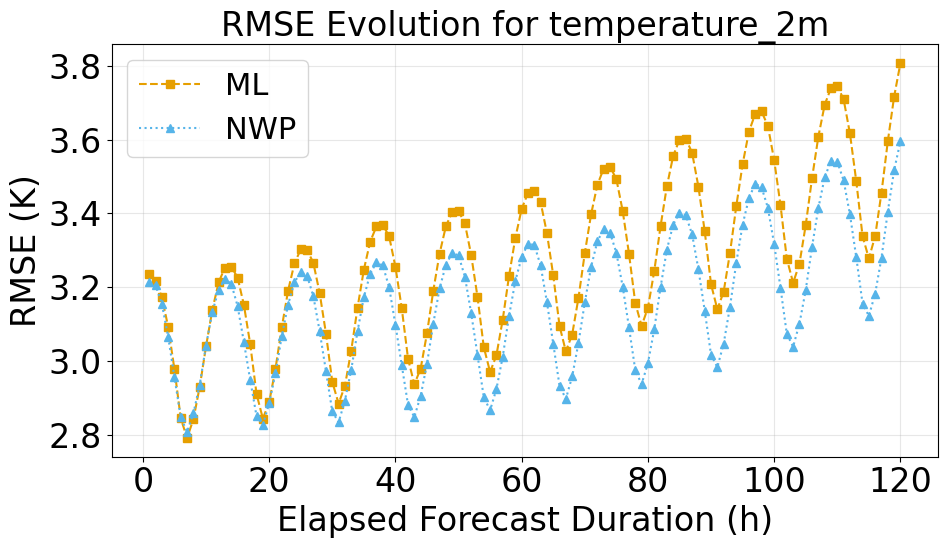

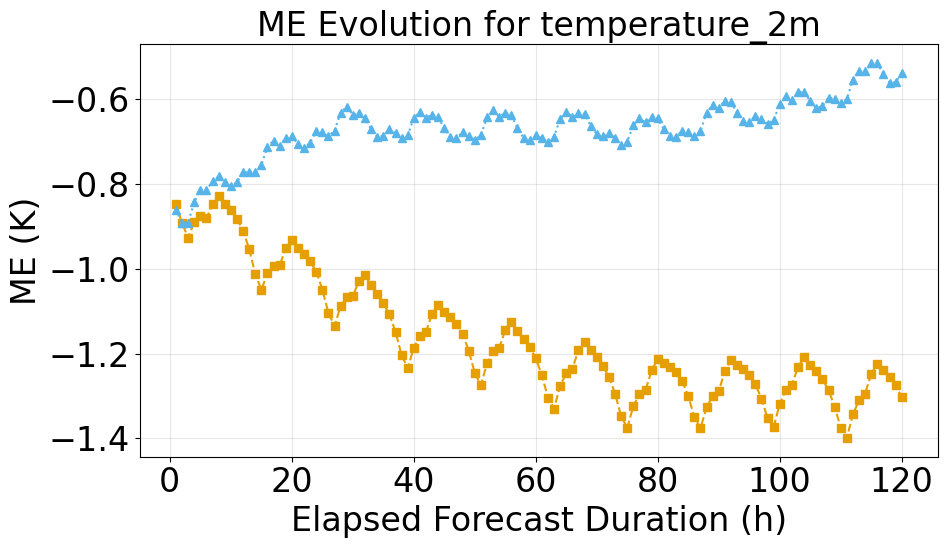

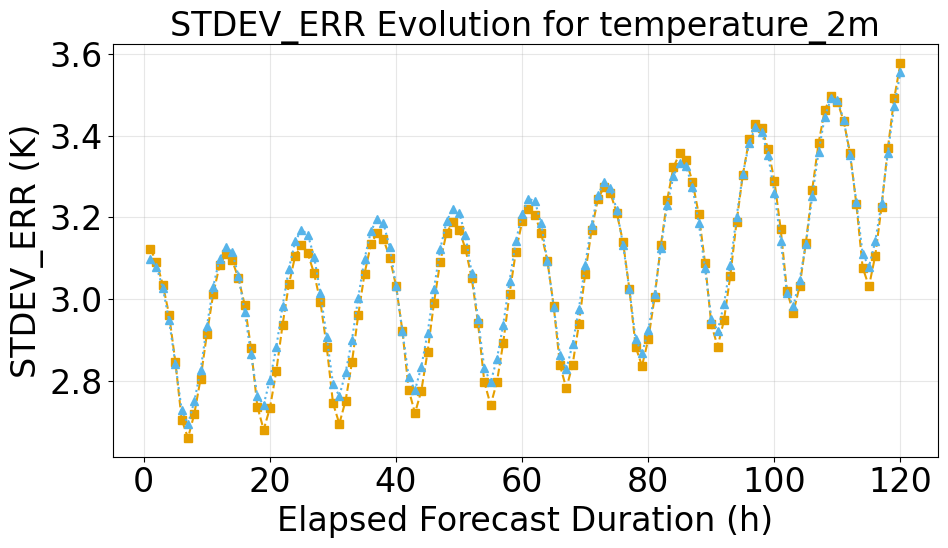

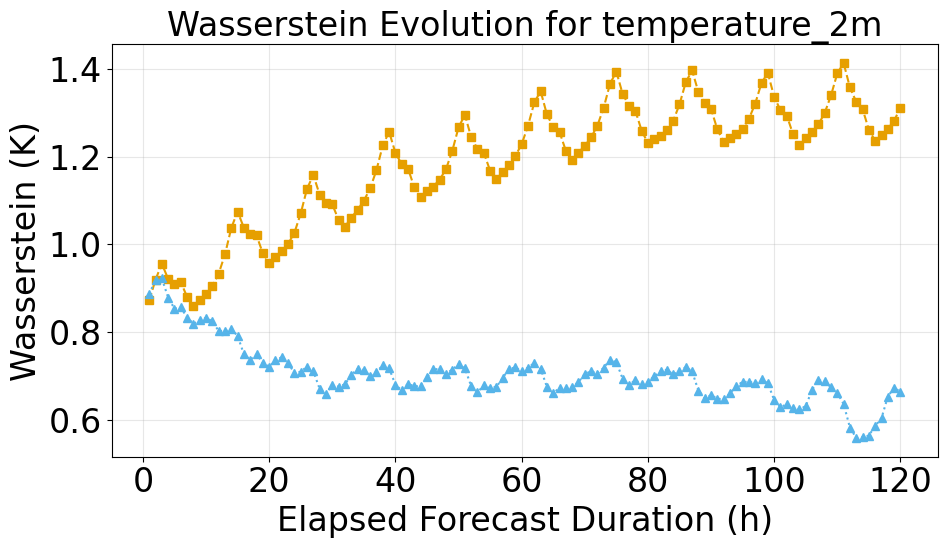

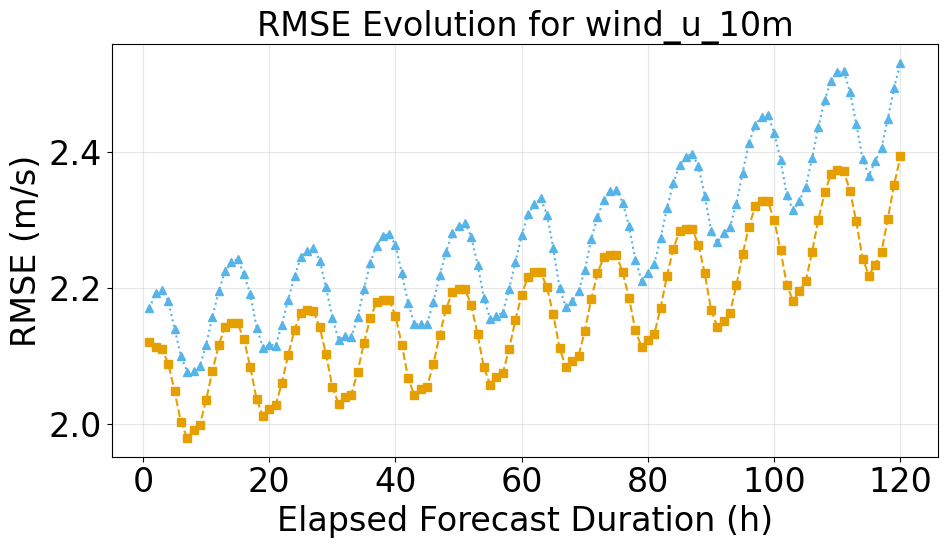

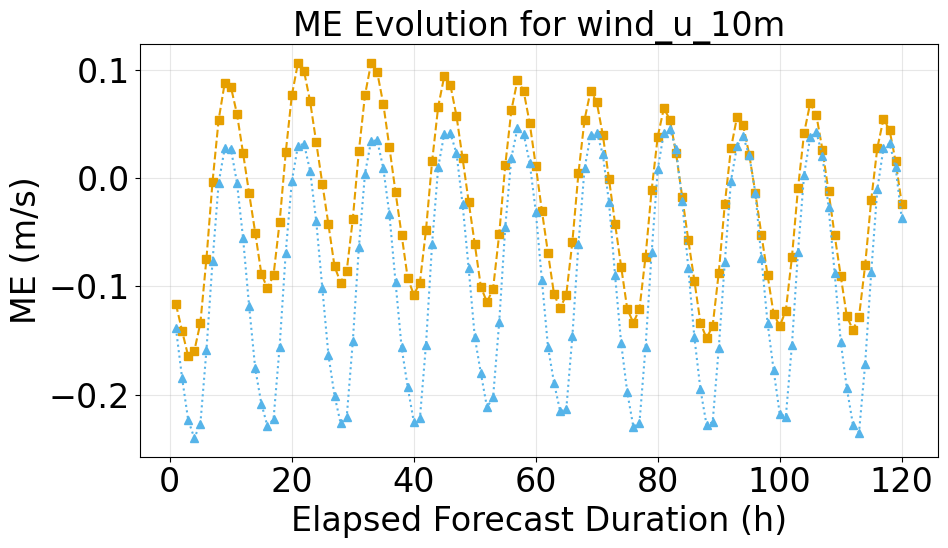

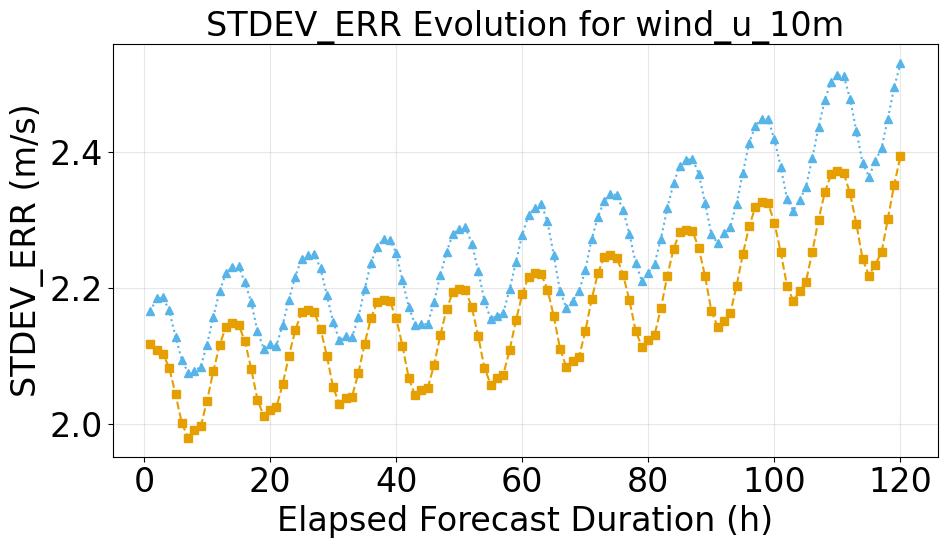

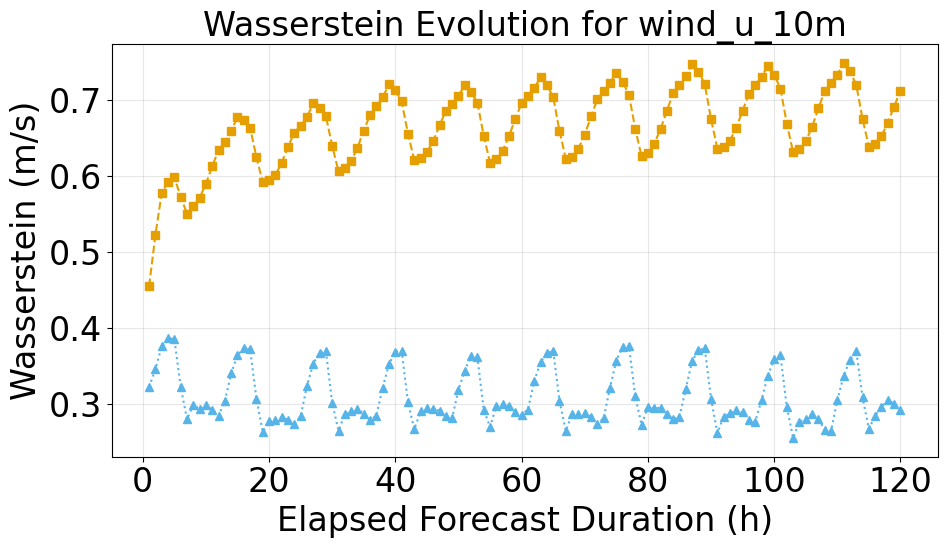

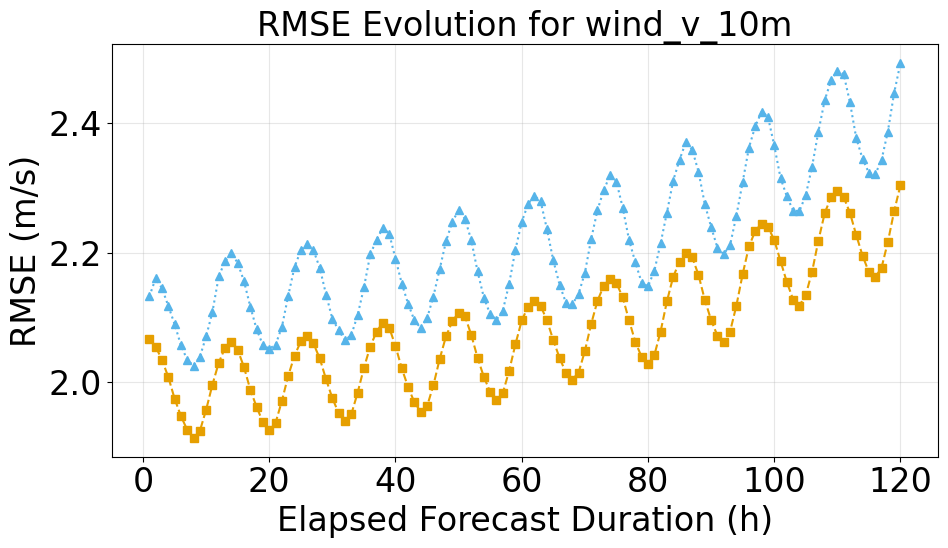

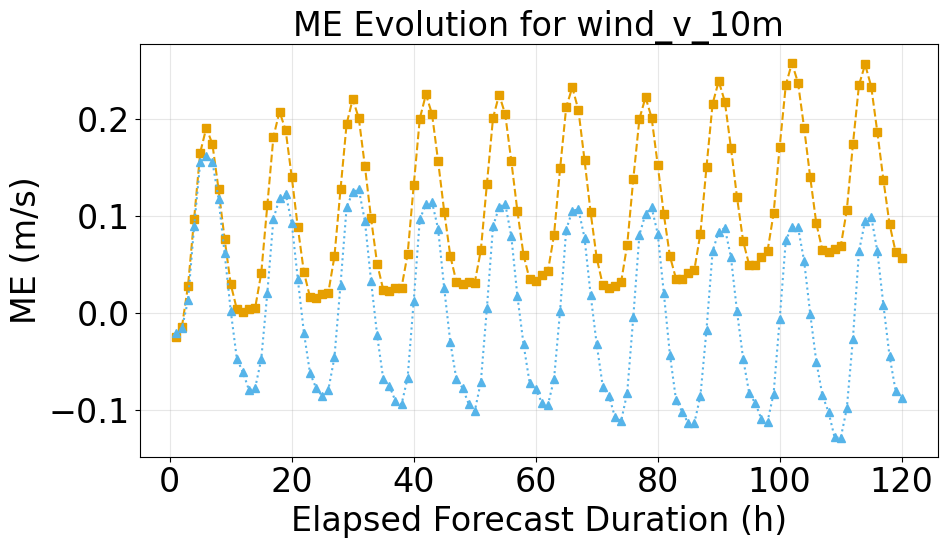

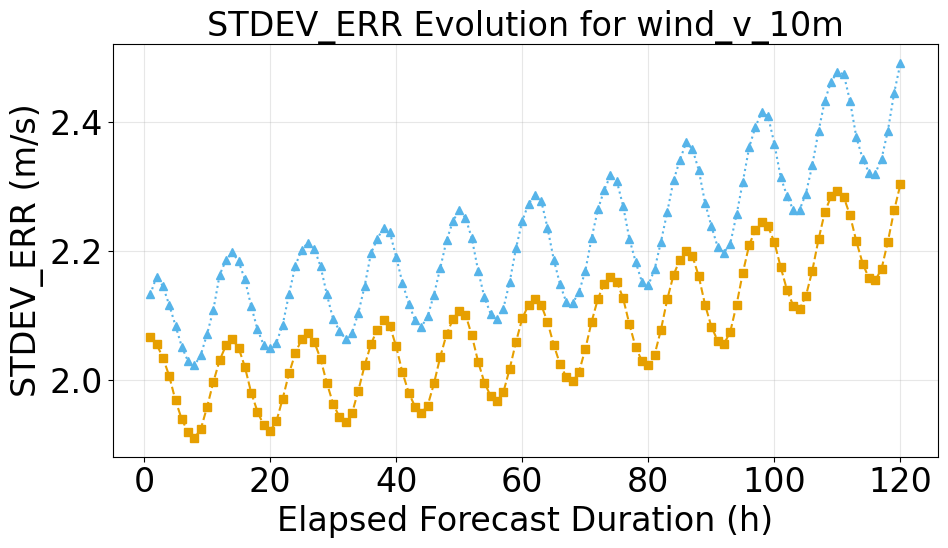

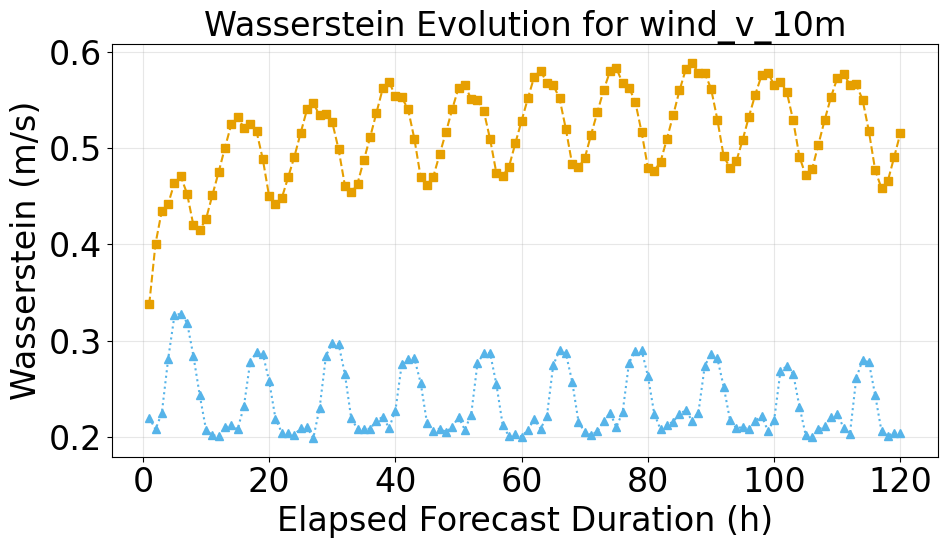

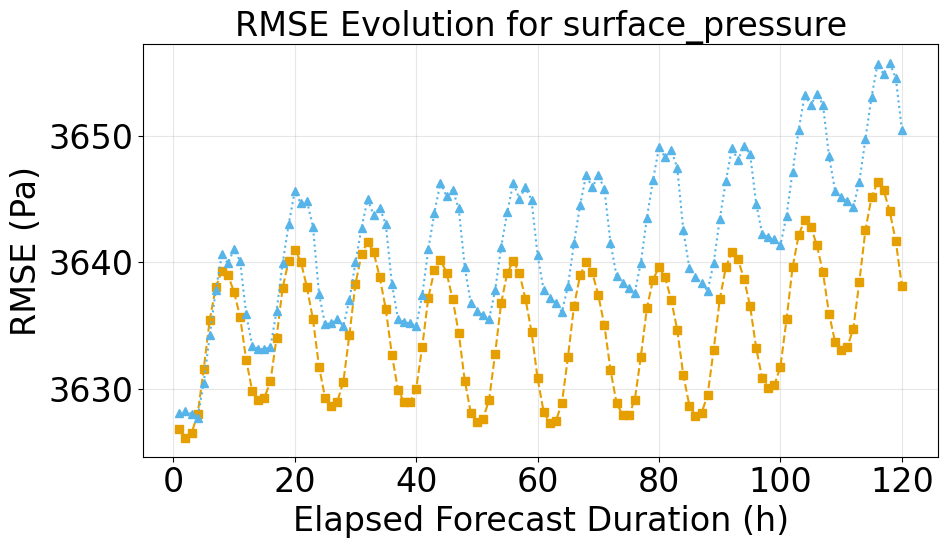

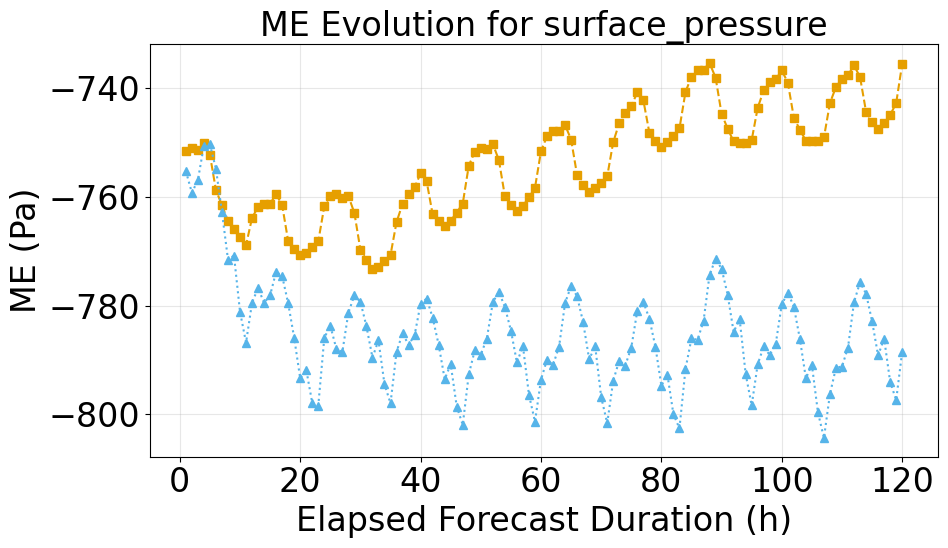

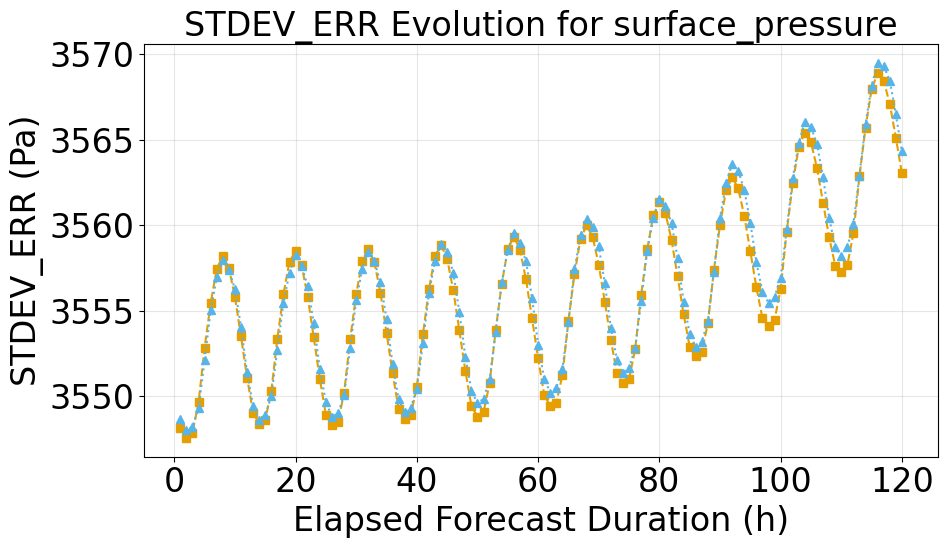

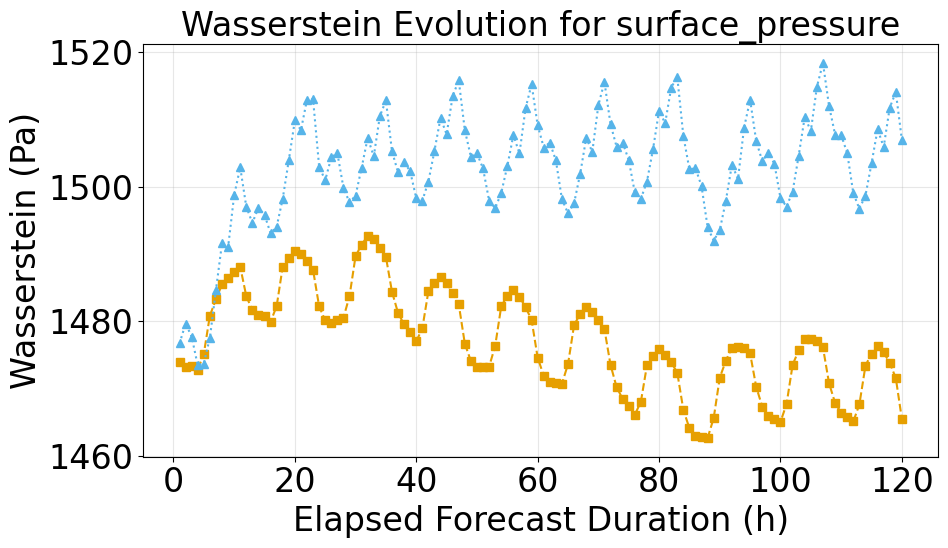

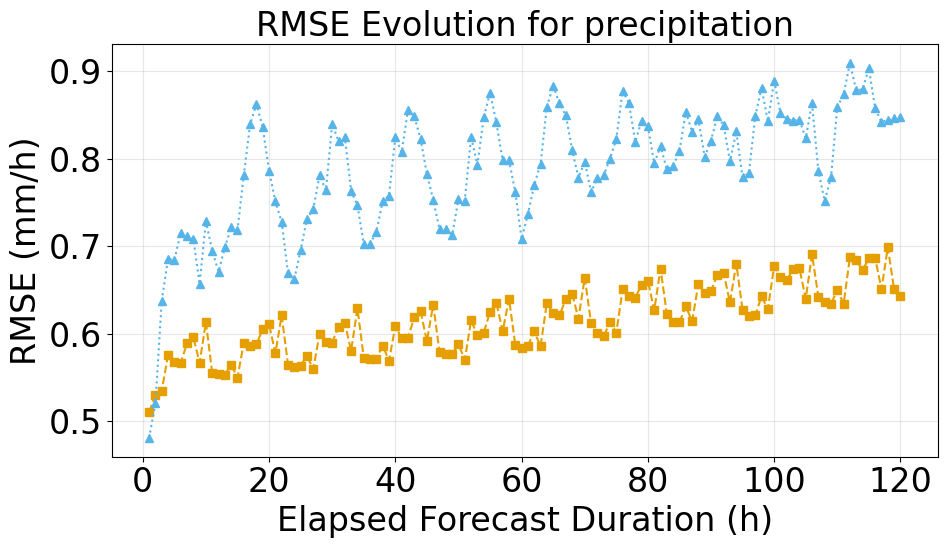

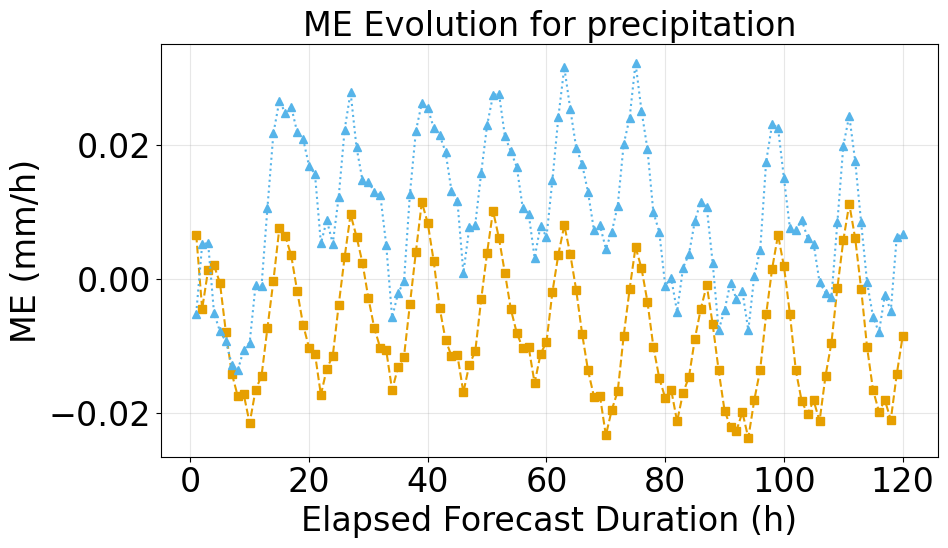

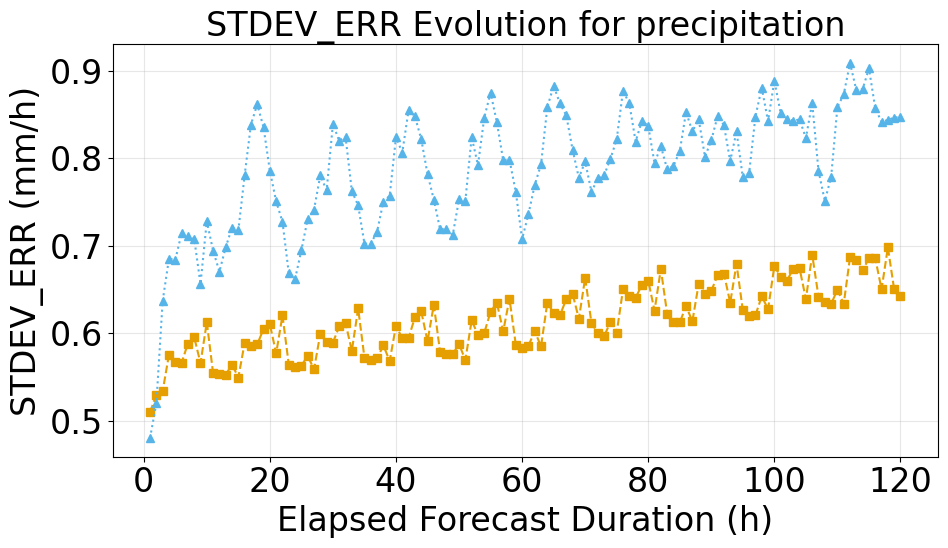

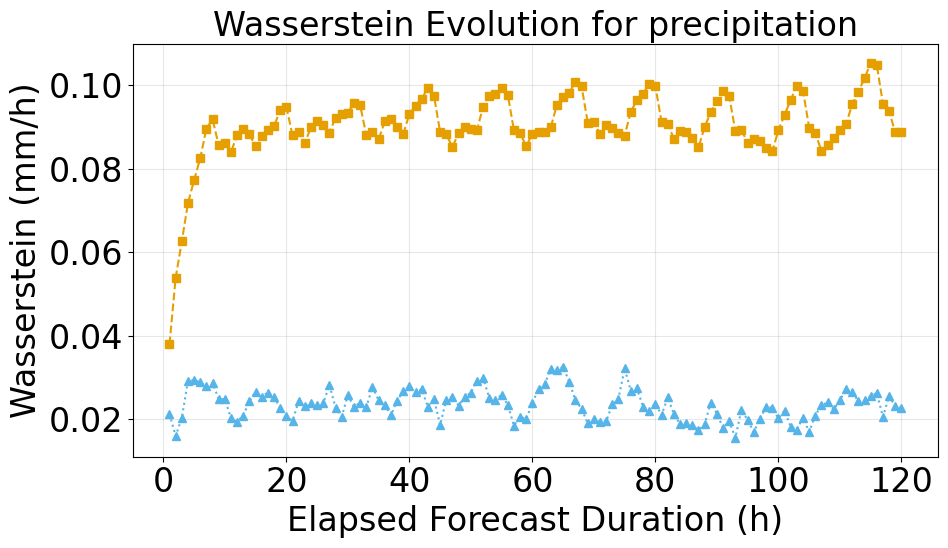

In [118]:
# Plot evolution of a specific metric over elapsed forecast duration
elapsed_forecast_durations = list(metrics_by_efd.keys())
metrics_to_compute = METRICS
plot_counter = 0
for variable in VARIABLES_ML.values():
    for metric in metrics_to_compute:
        try:
            # Skip if any scores are missing
            ml_scores = [
                df.loc[variable, f"{metric} ML"]
                for df in metrics_by_efd.values()
            ]
            nwp_scores = [
                df.loc[variable, f"{metric} NWP"]
                for df in metrics_by_efd.values()
            ]

            # Convert elapsed forecast durations from hours to timedelta
            hours = [
                x / np.timedelta64(1, "h")
                for x in ds_ml.elapsed_forecast_duration.values
            ]

            fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

            # Plot ML scores
            ax.plot(
                hours,
                ml_scores,
                label="ML",
                color=COLORS["ml"],
                linestyle=LINE_STYLES["ml"][0],
                marker=LINE_STYLES["ml"][1],
            )

            # Plot NWP scores if they exist and are not all NaN
            if not all(pd.isna(nwp_scores)):
                ax.plot(
                    hours,
                    nwp_scores,
                    label="NWP",
                    color=COLORS["nwp"],
                    linestyle=LINE_STYLES["nwp"][0],
                    marker=LINE_STYLES["nwp"][1],
                )

            ax.set_xlabel("Elapsed Forecast Duration (h)")
            ax.set_ylabel(f"{metric} ({VARIABLE_UNITS[variable]})")
            ax.set_title(f"{metric} Evolution for {variable}")
            ax.grid(True, alpha=0.3)
            # Only add legend for the first plot
            if plot_counter == 0:
                ax.legend()

            plot_counter += 1

            plt.tight_layout()
            plt.show()
            save_plot(fig, f"{metric}_{variable}_evolution")
            plt.close()

        except (KeyError, ValueError) as e:
            print(f"Skipping {metric} for {variable}: {str(e)}")
            continue

#### Equitable Threat Score (Traditional Version)
Range: [-1/3, 1], where:
- 1 = perfect score
- 0 = no skill compared to random chance
- -1/3 = worst possible performance

**Key Properties:**
- Measures how well predicted events correspond to observed events, accounting for hits due to random chance
- Particularly useful for rare events (like precipitation above a high threshold)
- More equitable than simple Threat Score by accounting for hits due to random chance

**Advantages:**
- Well-established metric in meteorological verification
- Reference point at 0 makes interpretation clear
- Penalizes both misses and false alarms
- Accounts for random chance, making it more robust than basic threat scores

#### Frequency Bias Index
Range: 0 to infinity, where:
- 1 = no bias
- < 1 = underforecasting
- > 1 = overforecasting

**Key Properties:**
- FBI measures the ratio of observed to forecasted events, indicating whether the model tends to over- or underforecast
- It's particularly useful for understanding systematic biases in event frequency

**Advantages:**
- Provides a clear indication of over- or underforecasting
- Easy to interpret: 1 indicates no bias, while values above or below 1 show the direction and magnitude of the bias

In [16]:
def calculate_meteoswiss_metrics(ds_obs, ds_ml, ds_nwp=None):
    """Calculate MeteoSwiss verification metrics (FBI and ETS) for station data."""
    metrics_by_var = {}

    # Get available variables in each dataset
    gt_ml_vars = set(ds_obs.variables) & set(ds_ml.variables)
    nwp_vars = set(ds_nwp.variables) if ds_nwp is not None else set()

    all_variables = {
        "precipitation": {
            "thresholds": THRESHOLDS_PRECIPITATION,
            "unit": "mm/h",
        },
        "wind_u_10m": {"thresholds": THRESHOLDS_WIND, "unit": "m/s"},
        "wind_v_10m": {"thresholds": THRESHOLDS_WIND, "unit": "m/s"},
    }

    # Filter variables that exist in gt and ml
    all_variables = {k: v for k, v in all_variables.items() if k in gt_ml_vars}

    # Initialize metrics structure
    for var_name in all_variables:
        metrics_by_var[var_name] = {}
        for thr in all_variables[var_name]["thresholds"]:
            metric_key = f"{thr}{all_variables[var_name]['unit']}"
            metrics_by_var[var_name][metric_key] = {
                "FBI_ML": [],
                "ETS_ML": [],
                "FBI_NWP": [] if ds_nwp is not None else None,
                "ETS_NWP": [] if ds_nwp is not None else None,
            }

    for efd in ds_ml.elapsed_forecast_duration.values:
        try:
            print(
                f"\nCalculating metrics for elapsed forecast duration: {efd / np.timedelta64(1, 'h'):.1f}h"
            )

            ds_ml_lead = ds_ml.sel(elapsed_forecast_duration=efd)
            ds_nwp_lead = (
                ds_nwp.sel(elapsed_forecast_duration=efd)
                if ds_nwp is not None
                else None
            )
            forecast_times = ds_ml_lead.forecast_time
            ds_obs_lead = ds_obs.sel(time=forecast_times)

            for var_name, var_config in all_variables.items():
                print(f"Processing {var_name}")
                try:
                    # Get data and create masks
                    y_true = ds_obs_lead[var_name]
                    y_ml = ds_ml_lead[var_name]
                    y_nwp = (
                        ds_nwp_lead[var_name]
                        if ds_nwp_lead is not None and var_name in nwp_vars
                        else None
                    )

                    # Create masks
                    mask_true = xr.where(~np.isnan(y_true), True, False)
                    mask_ml = xr.where(~np.isnan(y_ml), True, False)
                    if y_nwp is not None:
                        mask_nwp = xr.where(~np.isnan(y_nwp), True, False)
                        valid_mask = mask_true & mask_ml & mask_nwp
                    else:
                        valid_mask = mask_true & mask_ml

                    # Apply masks
                    y_true = y_true.where(valid_mask)
                    y_ml = y_ml.where(valid_mask)
                    if y_nwp is not None:
                        y_nwp = y_nwp.where(valid_mask)

                    for thr in var_config["thresholds"]:
                        metric_key = f"{thr}{var_config['unit']}"

                        # Calculate ML metrics using TEO
                        event_operator = TEO(default_event_threshold=thr)
                        ml_contingency = (
                            event_operator.make_contingency_manager(
                                y_ml, y_true
                            )
                        )

                        fbi_ml = ml_contingency.frequency_bias().values
                        ets_ml = ml_contingency.equitable_threat_score().values

                        metrics_by_var[var_name][metric_key]["FBI_ML"].append(
                            fbi_ml
                        )
                        metrics_by_var[var_name][metric_key]["ETS_ML"].append(
                            ets_ml
                        )

                        # Calculate NWP metrics if available
                        if y_nwp is not None:
                            nwp_contingency = (
                                event_operator.make_contingency_manager(
                                    y_nwp, y_true
                                )
                            )
                            fbi_nwp = nwp_contingency.frequency_bias().values
                            ets_nwp = (
                                nwp_contingency.equitable_threat_score().values
                            )

                            metrics_by_var[var_name][metric_key][
                                "FBI_NWP"
                            ].append(fbi_nwp)
                            metrics_by_var[var_name][metric_key][
                                "ETS_NWP"
                            ].append(ets_nwp)

                except Exception as e:
                    print(f"Error processing {var_name}: {str(e)}")
                    continue

        except Exception as e:
            print(f"Error processing elapsed forecast duration {efd}: {str(e)}")
            continue

    return metrics_by_var

In [122]:
def plot_meteoswiss_metrics_evolution(metrics_by_var, var_name, metric_prefix):
    """Plot evolution of MeteoSwiss metrics over forecast time with three fixed viridis colors."""
    # Get thresholds for this variable
    thresholds = list(metrics_by_var[var_name].keys())

    # Get three fixed colors from viridis (start, middle, end)
    colors = [plt.cm.viridis(x) for x in [0, 0.5, 0.99]]

    # Setup the plot
    fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

    # For each threshold
    for i, threshold in enumerate(thresholds):
        # Get ML and NWP metrics for this threshold
        ml_metric = f"{metric_prefix}_ML"
        nwp_metric = f"{metric_prefix}_NWP"

        # Extract values
        if ml_metric in metrics_by_var[var_name][threshold]:
            ml_values = metrics_by_var[var_name][threshold][ml_metric]
            ax.plot(
                range(1,len(ml_values)+1),
                ml_values,
                linestyle=LINE_STYLES["ml"][0],
                marker=LINE_STYLES["ml"][1],
                color=colors[i],
                label=f"ML {threshold}",
                markevery=3,
            )

        if nwp_metric in metrics_by_var[var_name][threshold]:
            nwp_values = metrics_by_var[var_name][threshold][nwp_metric]
            ax.plot(
                range(1,len(nwp_values)+1),
                nwp_values,
                linestyle=LINE_STYLES["nwp"][0],
                marker=LINE_STYLES["nwp"][1],
                color=colors[i],
                label=f"NWP {threshold}",
                markevery=3,
            )

    ax.set_xlabel("Elapsed Forecast Duration (h)")
    ax.set_ylabel(f"{metric_prefix}")
    ax.set_title(f"{metric_prefix} for {var_name}")
    ax.grid(True, alpha=0.3)
    if metric_prefix == "FBI":
        ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()
    save_plot(fig, f"{metric_prefix.lower()}_{var_name}_evolution")


In [ ]:
# Calculate MeteoSwiss metrics
def reshape_meteoswiss_metrics(metrics_dict, forecast_hours):
    """Reshape MeteoSwiss metrics into a DataFrame with variables/thresholds as columns and forecast hours as rows"""

    # Initialize DataFrame with MultiIndex columns
    columns = []
    values = []
    for var in metrics_dict:
        for threshold in metrics_dict[var]:
            for metric in metrics_dict[var][threshold]:
                col_name = f"{var}_{threshold}_{metric}"
                columns.append(col_name)
                # Extract values and convert from numpy arrays to floats
                metric_values = [
                    float(val) for val in metrics_dict[var][threshold][metric]
                ]
                values.append(metric_values)

    # Create DataFrame
    df = pd.DataFrame(np.array(values).T, columns=columns, index=forecast_hours)
    df.index.name = "forecast_hour"

    return df


# # Use it after calculate_meteoswiss_metrics
print("Calculating MeteoSwiss metrics...")
meteoswiss_metrics = calculate_meteoswiss_metrics(
    ds_obs,
    ds_ml_interp,
    ds_nwp_interp,
)
metrics_df = reshape_meteoswiss_metrics(
    meteoswiss_metrics,
    ds_ml.elapsed_forecast_duration.values.astype("timedelta64[h]").astype(int),
)

# Now export the reshaped DataFrame
export_table(
    metrics_df, "meteoswiss_metrics", caption="MeteoSwiss verification metrics"
)

Calculating MeteoSwiss metrics...

Calculating metrics for elapsed forecast duration: 1.0h
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 2.0h
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 3.0h
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 4.0h
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 5.0h
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 6.0h
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 7.0h
Processing precipitation
Processing wind_u_10m
Processing wind_v_10m

Calculating metrics for elapsed forecast duration: 8.0h
Processing precipitation
Pr

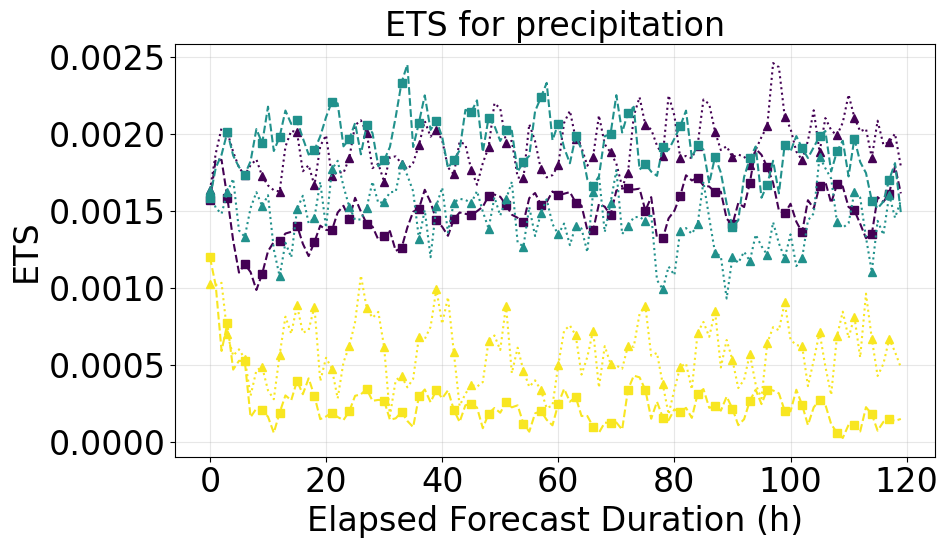

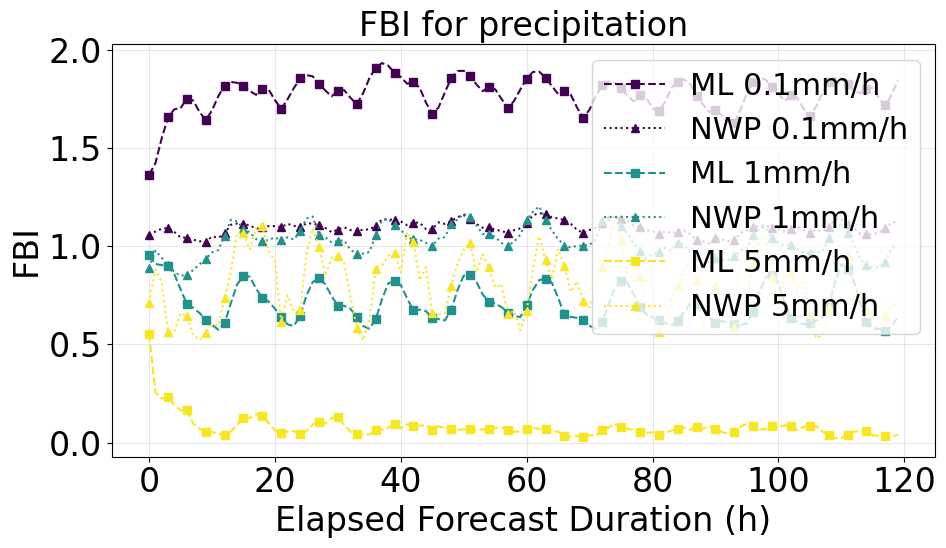

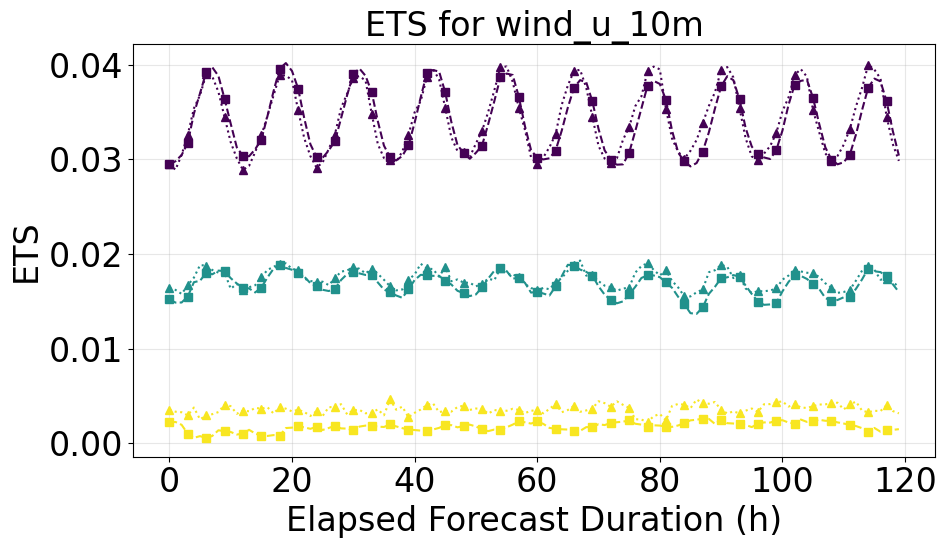

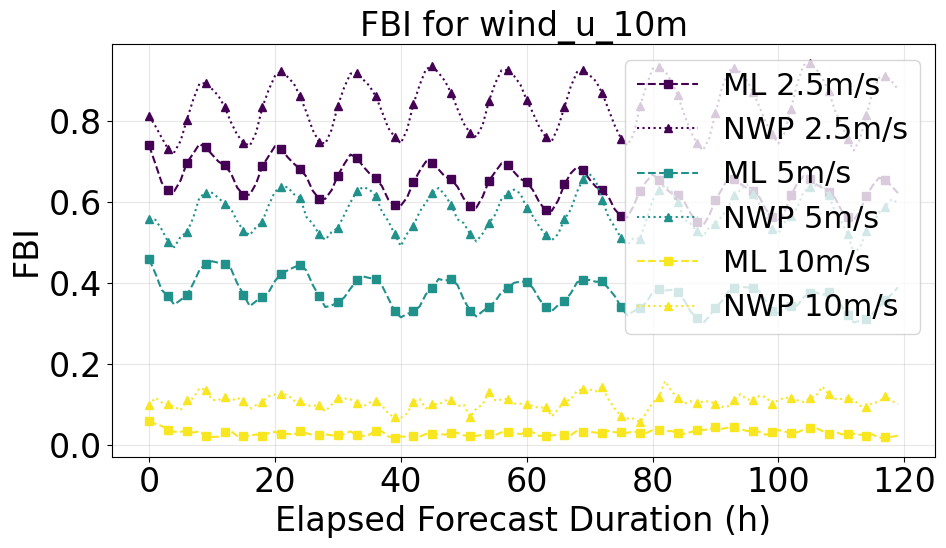

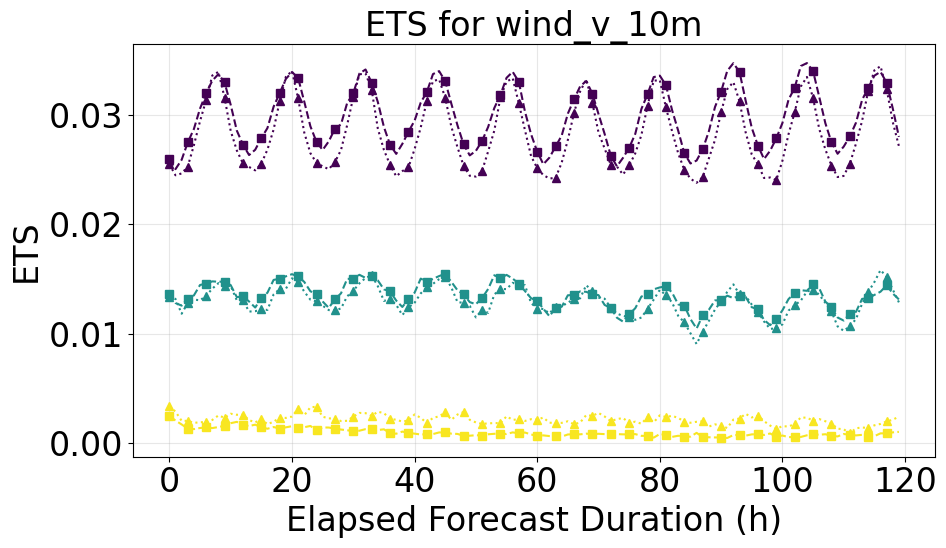

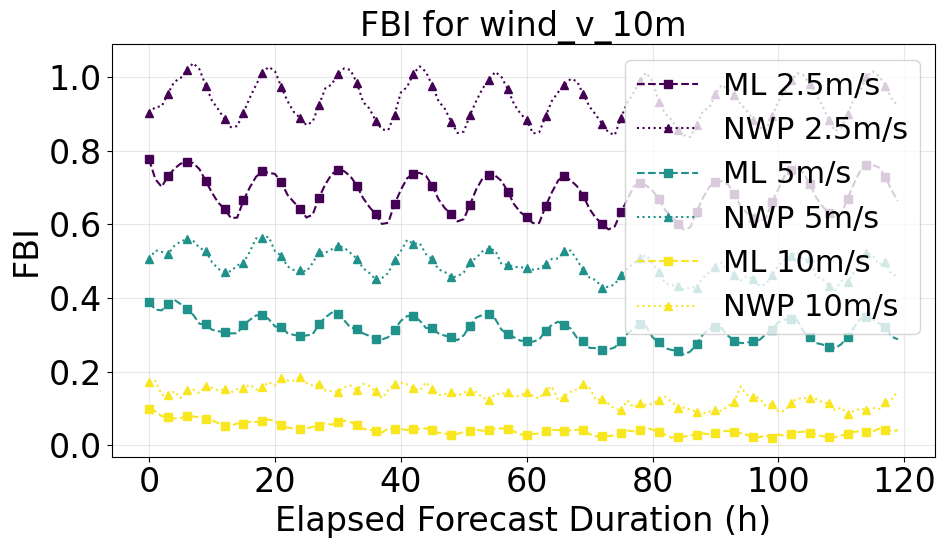

In [123]:
if "precipitation" in ds_obs:
    plot_meteoswiss_metrics_evolution(
        meteoswiss_metrics, "precipitation", "ETS"
    )
    plot_meteoswiss_metrics_evolution(
        meteoswiss_metrics, "precipitation", "FBI"
    )

if "wind_u_10m" in ds_obs:
    plot_meteoswiss_metrics_evolution(meteoswiss_metrics, "wind_u_10m", "ETS")
    plot_meteoswiss_metrics_evolution(meteoswiss_metrics, "wind_u_10m", "FBI")

if "wind_v_10m" in ds_obs:
    plot_meteoswiss_metrics_evolution(meteoswiss_metrics, "wind_v_10m", "ETS")
    plot_meteoswiss_metrics_evolution(meteoswiss_metrics, "wind_v_10m", "FBI")

The wind vector RMSE takes into account the magnitude and direction of the wind, providing a more comprehensive measure of error than scalar metrics.

In [20]:
def wind_vector_rmse(u_pred, v_pred, u_true, v_true):
    """Calculate RMSE based on wind vector differences."""
    u_diff = u_true - u_pred
    v_diff = v_true - v_pred
    vector_diff = np.sqrt(u_diff**2 + v_diff**2)
    return float(np.sqrt(np.mean(vector_diff**2)))


def calculate_wind_vector_metrics(ds_obs, ds_ml_interp, ds_nwp_interp=None):
    """Calculate wind vector metrics for station data.

    Args:
        ds_obs: xarray Dataset containing observations
        ds_ml_interp: xarray Dataset containing interpolated ML predictions
        ds_nwp_interp: xarray Dataset containing interpolated NWP predictions
    """

    # Get elapsed forecast durations
    elapsed_forecast_durations = ds_ml_interp.elapsed_forecast_duration
    forecast_hours = [
        float(efd / np.timedelta64(1, "h"))
        for efd in elapsed_forecast_durations
    ]

    # Initialize lists to store RMSE values over time
    ml_rmse_over_time = []
    nwp_rmse_over_time = []

    for efd in elapsed_forecast_durations:
        # Get ML data for this forecast lead time
        ds_ml_lead = ds_ml_interp.sel(elapsed_forecast_duration=efd)

        # Get observation times corresponding to these forecast times
        forecast_times = ds_ml_lead.forecast_time.values
        ds_obs_lead = ds_obs.sel(time=forecast_times)

        # Get wind components for observations and ML
        u_true = ds_obs_lead["wind_u_10m"].values
        v_true = ds_obs_lead["wind_v_10m"].values
        u_ml = ds_ml_lead["wind_u_10m"].values
        v_ml = ds_ml_lead["wind_v_10m"].values

        # Create valid mask
        valid_mask = (
            ~np.isnan(u_true)
            & ~np.isnan(v_true)
            & ~np.isnan(u_ml)
            & ~np.isnan(v_ml)
        )

        if np.any(valid_mask):
            # Calculate ML wind vector RMSE
            wind_rmse_ml = wind_vector_rmse(
                u_ml[valid_mask],
                v_ml[valid_mask],
                u_true[valid_mask],
                v_true[valid_mask],
            )
            ml_rmse_over_time.append(wind_rmse_ml)
        else:
            ml_rmse_over_time.append(np.nan)

        # Calculate NWP RMSE if available
        if (
            ds_nwp_interp is not None
            and "wind_u_10m" in ds_nwp_interp
            and "wind_v_10m" in ds_nwp_interp
        ):
            ds_nwp_lead = ds_nwp_interp.sel(elapsed_forecast_duration=efd)
            u_nwp = ds_nwp_lead["wind_u_10m"].values
            v_nwp = ds_nwp_lead["wind_v_10m"].values

            valid_mask_nwp = valid_mask & ~np.isnan(u_nwp) & ~np.isnan(v_nwp)

            if np.any(valid_mask_nwp):
                wind_rmse_nwp = wind_vector_rmse(
                    u_nwp[valid_mask_nwp],
                    v_nwp[valid_mask_nwp],
                    u_true[valid_mask_nwp],
                    v_true[valid_mask_nwp],
                )
                nwp_rmse_over_time.append(wind_rmse_nwp)
            else:
                nwp_rmse_over_time.append(np.nan)
        else:
            nwp_rmse_over_time.append(np.nan)

    # Create result DataFrame
    time_series_df = pd.DataFrame({
        "Elapsed Forecast Duration": forecast_hours,
        "ML Vector RMSE": ml_rmse_over_time,
        "NWP Vector RMSE": nwp_rmse_over_time,
    })

    return time_series_df

In [75]:
def plot_wind_vector_rmse(time_series_df):
    """Plot wind vector RMSE evolution over forecast time.

    Args:
        time_series_df: Time series DataFrame from calculate_wind_vector_metrics
    """
    fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

    # Plot ML RMSE
    ax.plot(
        time_series_df["Elapsed Forecast Duration"],
        time_series_df["ML Vector RMSE"],
        color=COLORS["ml"],
        linestyle=LINE_STYLES["ml"][0],
        marker=LINE_STYLES["ml"][1],
        label="ML",
    )

    # Plot NWP RMSE if available
    if not all(np.isnan(time_series_df["NWP Vector RMSE"])):
        ax.plot(
            time_series_df["Elapsed Forecast Duration"],
            time_series_df["NWP Vector RMSE"],
            color=COLORS["nwp"],
            linestyle=LINE_STYLES["nwp"][0],
            marker=LINE_STYLES["nwp"][1],
            label="NWP",
        )

    ax.set_xlabel("Forecast Lead Time (hours)")
    ax.set_ylabel("RMSE (m/s)")
    ax.set_title("Wind Vector RMSE Evolution")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    save_plot(fig, "wind_vector_rmse_evolution")

Calculating wind vector metrics...


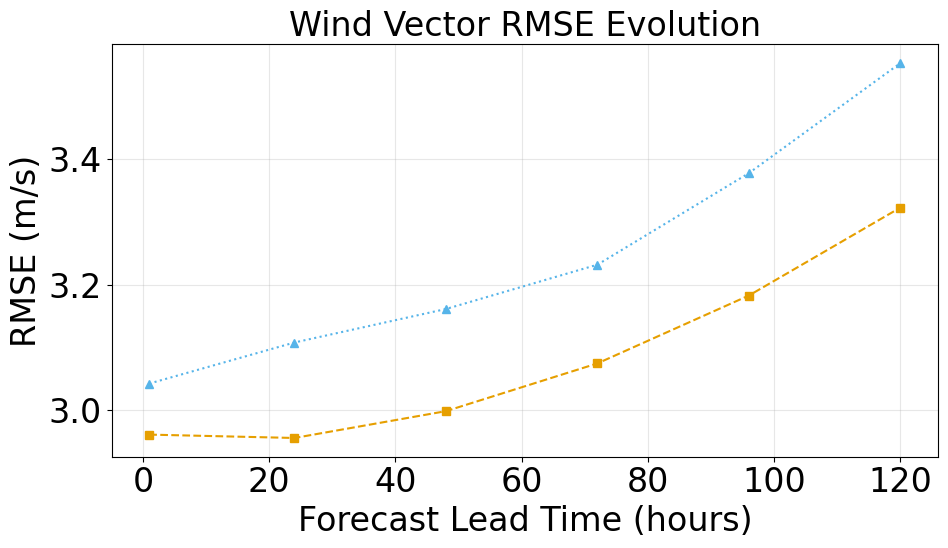

In [124]:
# Calculate wind vector metrics
if "wind_u_10m" in ds_obs and "wind_v_10m" in ds_obs:
    print("Calculating wind vector metrics...")
    wind_timeseries = calculate_wind_vector_metrics(
        ds_obs, ds_ml_interp, ds_nwp_interp
    )
    plot_wind_vector_rmse(wind_timeseries)
    export_table(
        wind_timeseries,
        "wind_vector_metrics_timeseries",
        caption="Wind vector RMSE over forecast lead time",
    )
else:
    print("Wind components not found in the data")